# Mono , SVM (rbf, rbf_Stand, Linear_Stand) - Arabic without Fine Tune

In [1]:
import os
from gensim.models import KeyedVectors
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD

english_embedding_path = "C:/Users/ALI/Desktop/wikis/wiki.en.vec"
arabic_embedding_path = "C:/Users/ALI/Desktop/wikis/Arabic fastText/wiki.ar.vec"

en_embeddings = KeyedVectors.load_word2vec_format(english_embedding_path)
ar_embeddings = KeyedVectors.load_word2vec_format(arabic_embedding_path)

def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# SVM rbf

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM with RBF kernel on the training set
svm = SVC(kernel='rbf')
history = svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.8398
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.84      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4164  797]
 [ 805 4234]]


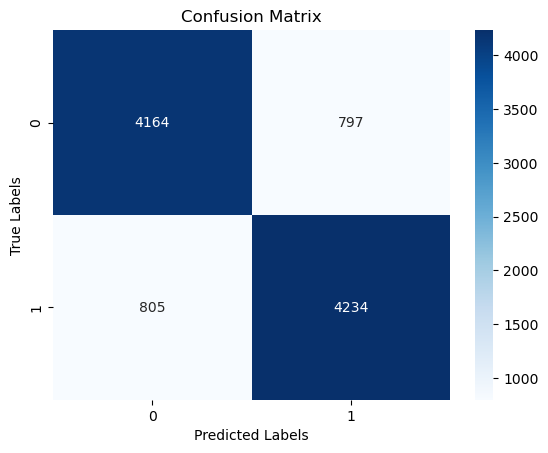

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Arabic

In [4]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()


# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(500, 7)
Accuracy: 0.5
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        80
    positive       0.50      1.00      0.67        80

    accuracy                           0.50       160
   macro avg       0.25      0.50      0.33       160
weighted avg       0.25      0.50      0.33       160



C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0 80]
 [ 0 80]]


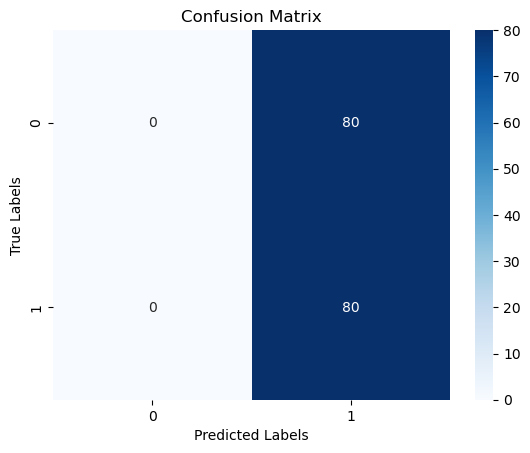

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# SVM rbf Stand

In [6]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM with RBF kernel on the standardized training set
svm = SVC(kernel='rbf')
history = svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the standardized testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8549
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      4961
    positive       0.85      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



[[4217  744]
 [ 707 4332]]


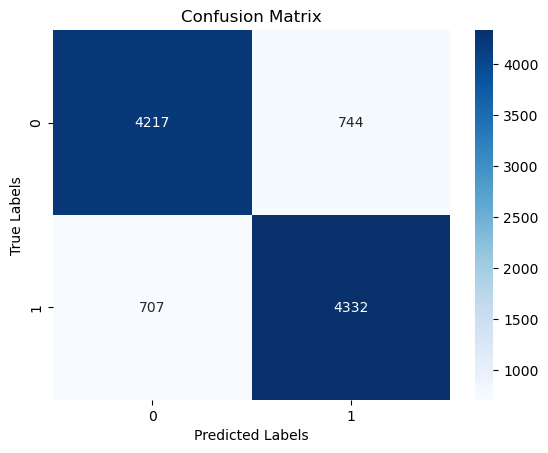

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Arabic

In [8]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
# df.head()


# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(500, 7)
Accuracy: 0.49375
              precision    recall  f1-score   support

    negative       0.50      0.97      0.66        80
    positive       0.33      0.01      0.02        80

    accuracy                           0.49       160
   macro avg       0.42      0.49      0.34       160
weighted avg       0.42      0.49      0.34       160



[[78  2]
 [79  1]]


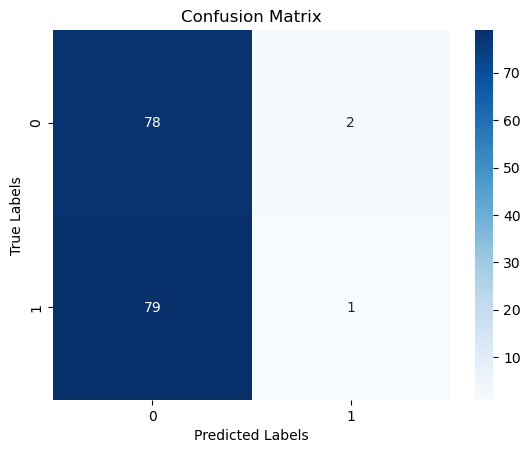

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# SVM Linear Stand

In [10]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM with linear kernel on the standardized training set
svm = SVC(kernel='linear')
history = svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the standardized testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8388
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.84      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4168  793]
 [ 819 4220]]


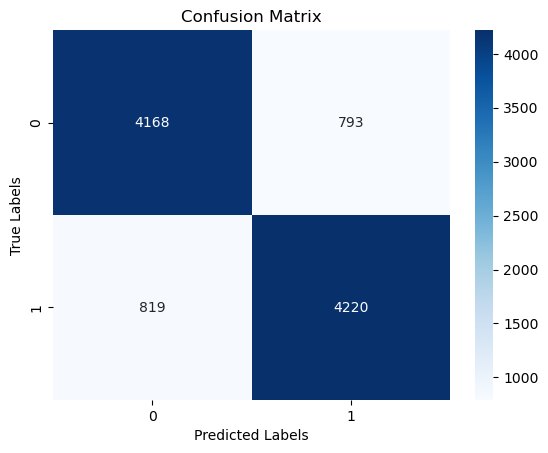

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Arabic|

In [12]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
# df.head()


# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(500, 7)
Accuracy: 0.48125
              precision    recall  f1-score   support

    negative       0.47      0.29      0.36        80
    positive       0.49      0.68      0.57        80

    accuracy                           0.48       160
   macro avg       0.48      0.48      0.46       160
weighted avg       0.48      0.48      0.46       160



[[23 57]
 [26 54]]


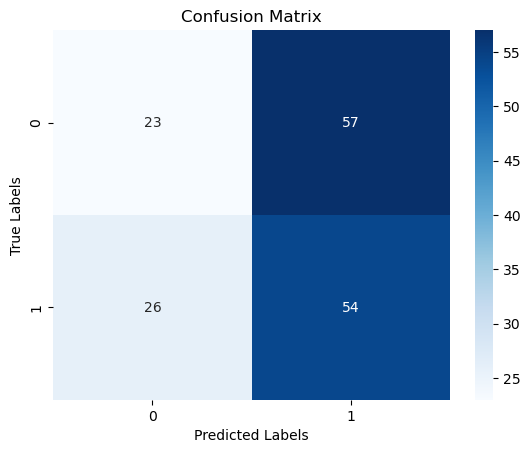

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()